In [1]:
import pandas as pd
import numpy as np
import os
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import load_model



In [2]:
# Paths
MODELS_FOLDER = os.path.join("data", "DNN_trained_models")
LOG_FILE = os.path.join("data", "DNN_trained_models_docs.csv")
SIM_DATA_FILE = os.path.join("data", "COMSOL", "results_3D_GE_Applied_Current_1MKOH_63_03_1MKOH_input_parameters_DOE_maximin_lhs_success_001.csv")
FIG_FOLDER = "figures"
BEST_MODEL = "model_results_3D_GE_Applied_Current_1MKOH_63_03_1MKOH_input_parameters_DOE_maximin_lhs_success_001__250616_191415"
os.makedirs(FIG_FOLDER, exist_ok=True)

df = pd.read_csv(SIM_DATA_FILE)
print(f"Dataset shape: {df.shape}")
df.head()


Dataset shape: (10830, 14)


,W_mem [m],W_GDE [m],T [degC],sigmas_MGL370 [S/m],sigmas_SS316L [S/m],eps_H2,eps_O2,v_in_H2 [m/s],v_in_O2 [m/s],p_gas [Pa],i0_ref_O2 [A/m^2],i0_ref_H2 [A/m^2],Time_s,Voltage_V
0,0.000081,0.000569,66.5948,48046200.0,613359.0,0.754929,0.625938,0.002791,0.004267,3827120.0,0.045859,0.035484,0.000000,1.19699
1,0.000081,0.000569,66.5948,48046200.0,613359.0,0.754929,0.625938,0.002791,0.004267,3827120.0,0.045859,0.035484,0.001000,1.20036
2,0.000081,0.000569,66.5948,48046200.0,613359.0,0.754929,0.625938,0.002791,0.004267,3827120.0,0.045859,0.035484,0.001585,1.20311
3,0.000081,0.000569,66.5948,48046200.0,613359.0,0.754929,0.625938,0.002791,0.004267,3827120.0,0.045859,0.035484,0.002513,1.20748
4,0.000081,0.000569,66.5948,48046200.0,613359.0,0.754929,0.625938,0.002791,0.004267,3827120.0,0.045859,0.035484,0.003984,1.21440


In [3]:
input_cols = [
    "W_mem [m]", "W_GDE [m]", "T [degC]", "sigmas_MGL370 [S/m]",
    "sigmas_SS316L [S/m]", "eps_H2", "eps_O2", "v_in_H2 [m/s]",
    "v_in_O2 [m/s]", "p_gas [Pa]", "i0_ref_O2 [A/m^2]", "i0_ref_H2 [A/m^2]"
]

output_col = "Voltage_V"

# Group the dataset by unique parameter sets (i.e., each trial)
grouped = df.groupby(input_cols)
print(f"Total number of trials: {len(grouped)}")


Total number of trials: 361


In [4]:
# Select trial index
trial_index = 100
trial_df = list(grouped)[trial_index][1].copy()

# Define input columns
input_cols = [
    "W_mem [m]", "W_GDE [m]", "T [degC]", "sigmas_MGL370 [S/m]",
    "sigmas_SS316L [S/m]", "eps_H2", "eps_O2", "v_in_H2 [m/s]",
    "v_in_O2 [m/s]", "p_gas [Pa]", "i0_ref_O2 [A/m^2]", "i0_ref_H2 [A/m^2]"
]

# Extract static inputs from one row of the trial
base_inputs = trial_df[input_cols].iloc[0].copy()

# Generate smooth Time_s (current) values
current_range = np.linspace(trial_df["Time_s"].min(), trial_df["Time_s"].max(), 200)

# Create synthetic inputs with varying current
synthetic_input = pd.DataFrame([base_inputs] * len(current_range))
synthetic_input["Time_s"] = current_range

# Full input order
model_inputs = input_cols + ["Time_s"]
X_smooth = synthetic_input[model_inputs].values

# Load scaler used during training
model_base = BEST_MODEL
scaler_path = os.path.join(MODELS_FOLDER, f"{model_base}_scaler.pkl")
scaler = joblib.load(scaler_path)
X_scaled = scaler.transform(X_smooth)

In [5]:
model_path = os.path.join(MODELS_FOLDER, f"{model_base}.keras")
model = tf.keras.models.load_model(model_path)

# Predict using smooth current range
y_pred = model.predict(X_scaled).flatten()


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


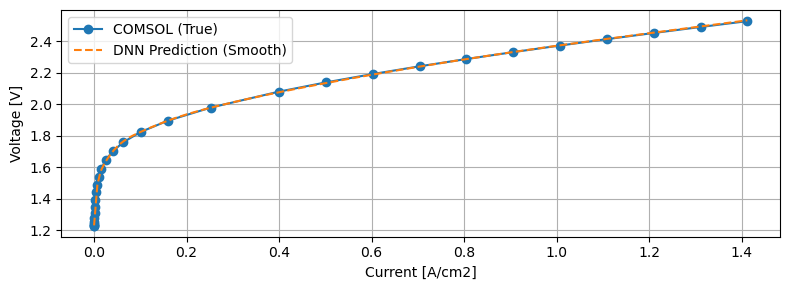

In [6]:
plt.figure(figsize=(8, 3))
plt.plot(trial_df["Time_s"]/10, trial_df["Voltage_V"], label="COMSOL (True)", marker="o")
plt.plot(current_range/10, y_pred, label="DNN Prediction (Smooth)", linestyle="--")
plt.xlabel("Current [A/cm2]")
plt.ylabel("Voltage [V]")
# plt.title(f"IV Curve — Trial #{trial_index}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


339/339 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


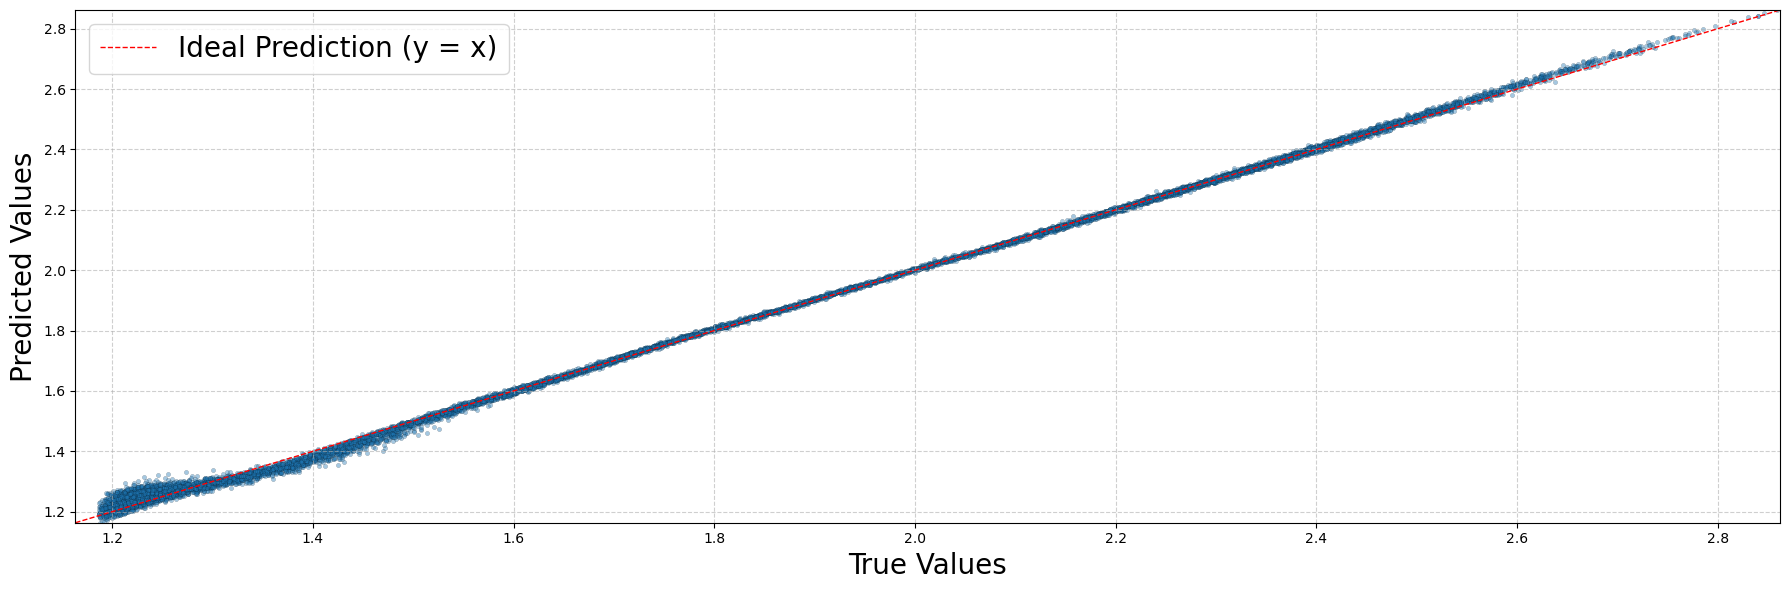

In [7]:


# --- Load model and scaler ---
model_path = os.path.join(MODELS_FOLDER, BEST_MODEL + ".keras")
scaler_path = os.path.join(MODELS_FOLDER, BEST_MODEL + "_scaler.pkl")
data_path = SIM_DATA_FILE

model = load_model(model_path)
scaler = joblib.load(scaler_path)

# --- Load and prepare data ---
import pandas as pd
df = pd.read_csv(data_path)
X = df.iloc[:, :-1].values  # assume last column is target
y_true = df.iloc[:, -1].values.reshape(-1, 1)
X_scaled = scaler.transform(X)

# --- Predict ---
y_pred = model.predict(X_scaled)

import numpy as np
import matplotlib.pyplot as plt

# Flatten and clean data
y_true_clean = y_true.flatten()
y_pred_clean = y_pred.flatten()

# Remove any pairs where either value is NaN or Inf
valid_mask = np.isfinite(y_true_clean) & np.isfinite(y_pred_clean)
y_true_clean = y_true_clean[valid_mask]
y_pred_clean = y_pred_clean[valid_mask]

# Plot
plt.figure(figsize=(18, 6))
plt.scatter(y_true_clean, y_pred_clean, alpha=0.4, edgecolor="k", linewidth=0.2, s=10)

# xl = 1
# yl =3


min_val = min(y_true_clean.min(), y_pred_clean.min())
max_val = max(y_true_clean.max(), y_pred_clean.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=1, label="Ideal Prediction (y = x)")
# plt.xlim(xl, yl)
# plt.ylim(xl, yl)
plt.xlabel("True Values", fontsize=20)
plt.ylabel("Predicted Values", fontsize=20)
# plt.title("Predicted vs Actual – Best Model", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
# plt.axis("equal")
plt.xlim(min_val, max_val)
plt.ylim(min_val, max_val)
plt.legend(fontsize=20)
plt.tight_layout()
# plt.savefig("IMAGES/predicted_vs_actual.png", dpi=300)
plt.show()



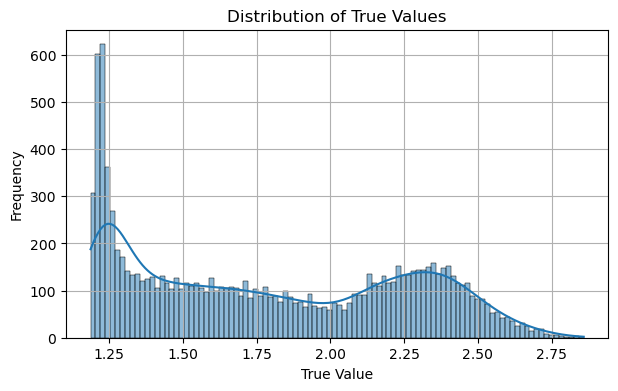

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 4))
sns.histplot(y_true.flatten(), bins=100, kde=True)
plt.title("Distribution of True Values")
plt.xlabel("True Value")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


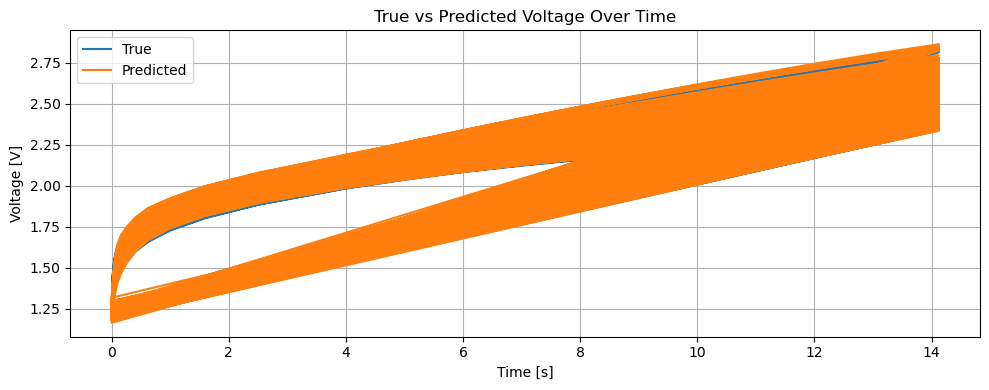

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(df["Time_s"], y_true, label="True")
plt.plot(df["Time_s"], y_pred, label="Predicted", alpha=1)
plt.xlabel("Time [s]")
plt.ylabel("Voltage [V]")
plt.title("True vs Predicted Voltage Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()


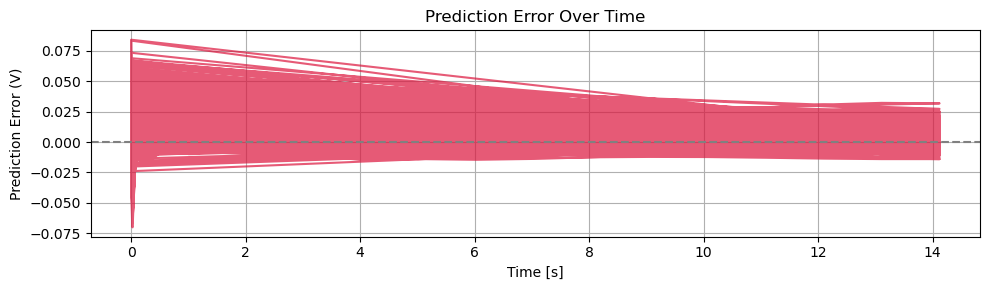

In [10]:
errors = y_pred.flatten() - y_true.flatten()
plt.figure(figsize=(10, 3))
plt.plot(df["Time_s"], errors, color="crimson", alpha=0.7)
plt.axhline(0, linestyle='--', color='gray')
plt.ylabel("Prediction Error (V)")
plt.xlabel("Time [s]")
plt.title("Prediction Error Over Time")
plt.grid(True)
plt.tight_layout()


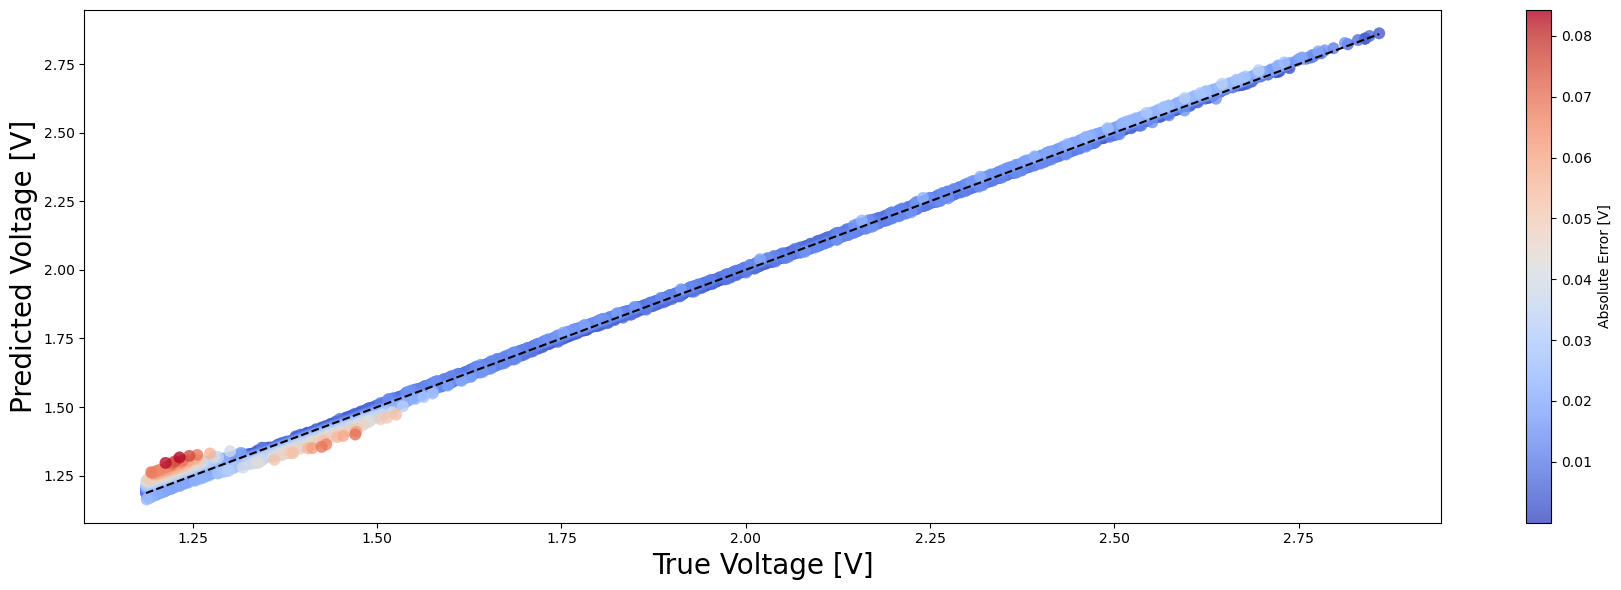

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Compute error and flatten
y_true_flat = y_true.flatten()
y_pred_flat = y_pred.flatten()
error = np.abs(y_pred_flat - y_true_flat)

# Sort by error magnitude (low to high)
sorted_indices = np.argsort(error)
y_true_sorted = y_true_flat[sorted_indices]
y_pred_sorted = y_pred_flat[sorted_indices]
error_sorted = error[sorted_indices]

# Plot
plt.figure(figsize=(18, 6))
sc = plt.scatter(
    y_true_sorted, 
    y_pred_sorted, 
    c=error_sorted, 
    cmap="coolwarm", 
    alpha=0.8, 
    linewidth=0.2, 
    s=70
)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
plt.xlabel("True Voltage [V]", fontsize=20)
plt.ylabel("Predicted Voltage [V]", fontsize=20)
plt.colorbar(sc, label="Absolute Error [V]")
plt.tight_layout()
plt.show()


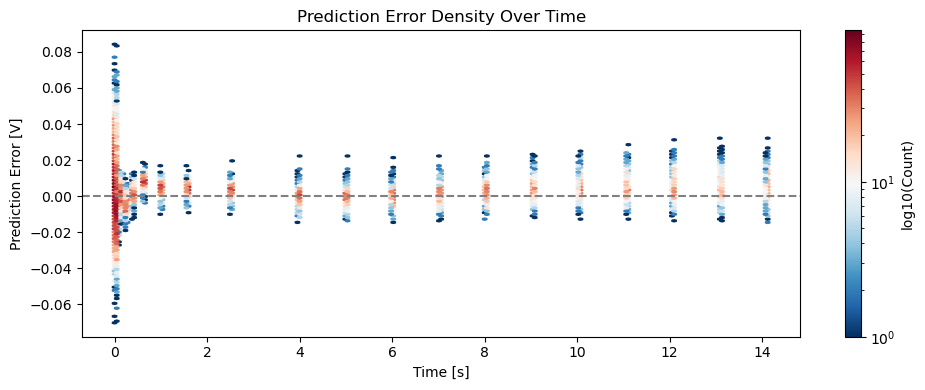

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Assume y_pred and y_true are flattened across all simulations
errors = (y_pred.flatten() - y_true.flatten()).astype(float)
times = df["Time_s"].values.flatten()

plt.figure(figsize=(10, 4))
plt.hexbin(times, errors, gridsize=150, cmap="RdBu_r", bins="log")
plt.colorbar(label="log10(Count)")
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Time [s]")
plt.ylabel("Prediction Error [V]")
plt.title("Prediction Error Density Over Time")
plt.tight_layout()
# plt.savefig("IMAGES/prediction_error_density.png", dpi=300)
plt.show()


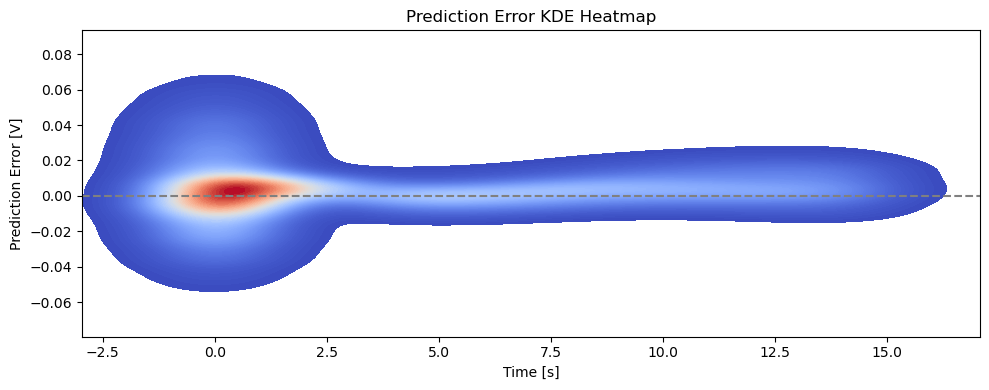

In [13]:
import seaborn as sns
plt.figure(figsize=(10, 4))
sns.kdeplot(x=times, y=errors, fill=True, cmap="coolwarm", levels=100, thresh=0.01)
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Time [s]")
plt.ylabel("Prediction Error [V]")
plt.title("Prediction Error KDE Heatmap")
plt.tight_layout()
# plt.savefig("IMAGES/prediction_error_kde.png", dpi=300)
plt.show()


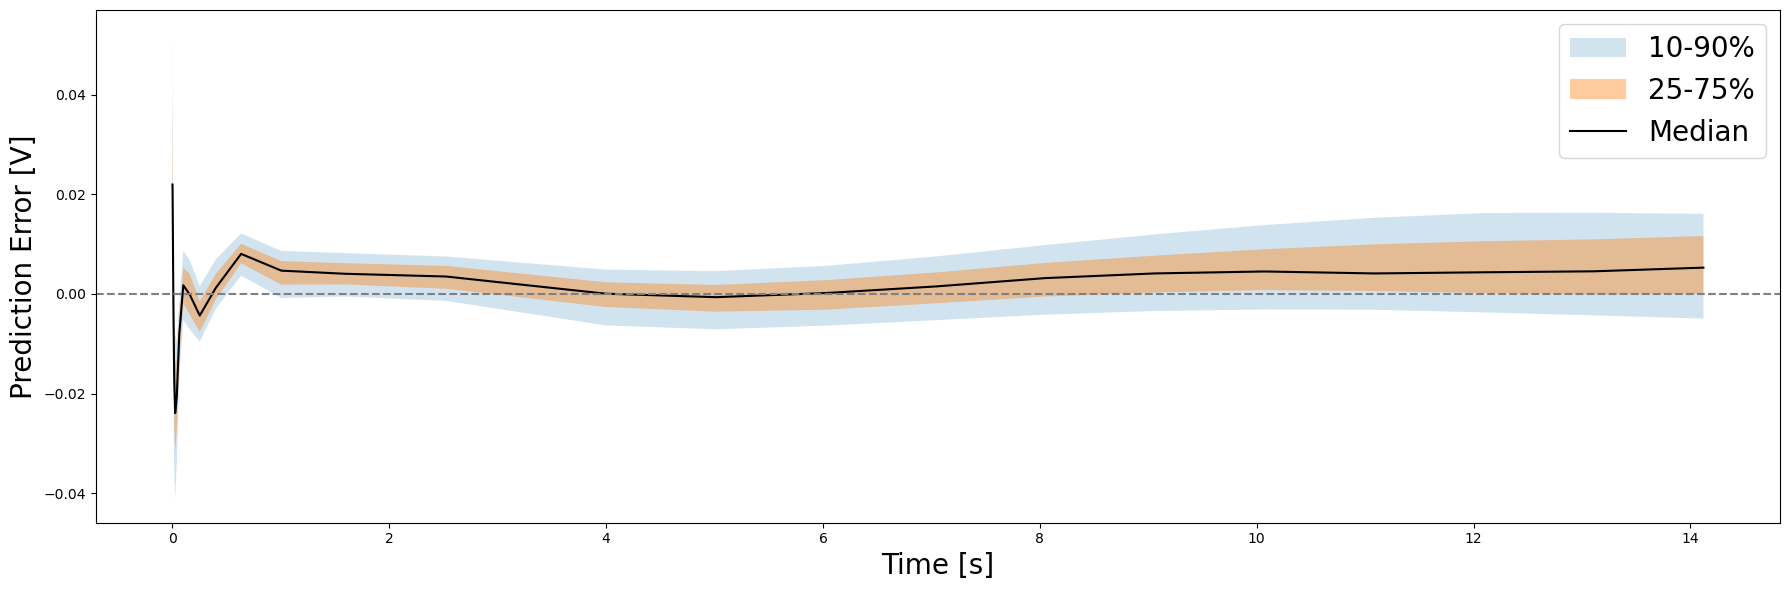

In [14]:
import pandas as pd

# Build DataFrame grouped by time
df_errors = pd.DataFrame({
    "Time": df["Time_s"].values.flatten(),
    "Error": (y_pred.flatten() - y_true.flatten())
})

percentiles = df_errors.groupby("Time")["Error"].quantile([0.1, 0.25, 0.5, 0.75, 0.9]).unstack()

plt.figure(figsize=(18, 6))
plt.fill_between(percentiles.index, percentiles[0.1], percentiles[0.9], alpha=0.2, label="10-90%")
plt.fill_between(percentiles.index, percentiles[0.25], percentiles[0.75], alpha=0.4, label="25-75%")
plt.plot(percentiles.index, percentiles[0.5], label="Median", color="black")
plt.axhline(0, linestyle='--', color='gray')
plt.xlabel("Time [s]", fontsize=20)
plt.ylabel("Prediction Error [V]", fontsize=20)
# plt.title("Prediction Error Quantiles Over Time")
plt.legend(fontsize=20)
plt.tight_layout()
# plt.savefig("IMAGES/prediction_error_bands.png", dpi=300)
plt.show()
